### Using Pandas together with SQL

In [5]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (15, 5)

In [6]:
# Install the SQLAlchemy library if it is not installed
!sudo -H pip3 install -U sqlalchemy

Requirement already up-to-date: sqlalchemy in /usr/local/lib/python3.5/dist-packages


### Importing into DataFrames using read_sql

The `read_sql` function of Pandas allows us to create a dataframe directly from a SQL query. To execute the query, we first setup the connection to the database using the SQLAlchemy library.

In [7]:
from sqlalchemy import create_engine

In [8]:
conn_string_imdb = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='root', 
    password='dwdstudent2015', 
    host = 'localhost', 
    port=3306, 
    db='imdb',
    encoding = 'utf-8'
)
engine_imdb = create_engine(conn_string_imdb)

#### Retrieve the first 10 lines from the actors table 

In [9]:
query = '''
SELECT * FROM actors LIMIT 10
'''

In [10]:
df_actors = pd.read_sql(query, con=engine_imdb)

In [11]:
df_actors

,id,first_name,last_name,gender
0,2,Michael,'babeepower' Viera,M
1,3,Eloy,'Chincheta',M
2,4,Dieguito,'El Cigala',M
3,5,Antonio,'El de Chipiona',M
4,6,José,'El Francés',M
5,7,Félix,'El Gato',M
6,8,Marcial,'El Jalisco',M
7,9,José,'El Morito',M
8,10,Francisco,'El Niño de la Manola',M
9,11,Víctor,'El Payaso',M


#### Retrieve the number of movies per year

In [12]:
query = '''
SELECT year, COUNT(*) AS num_movies, COUNT(rank) AS rated_movies
FROM movies 
GROUP BY year
ORDER BY year
'''

In [13]:
df_movies = pd.read_sql(query, con=engine_imdb)

In [14]:
df_movies

,year,num_movies,rated_movies
0,1888,2,0
1,1890,3,1
2,1891,6,6
3,1892,9,9
4,1893,2,1
5,1894,59,18
6,1895,72,34
7,1896,410,43
8,1897,688,66
9,1898,1004,79


Let's try to plot the results.

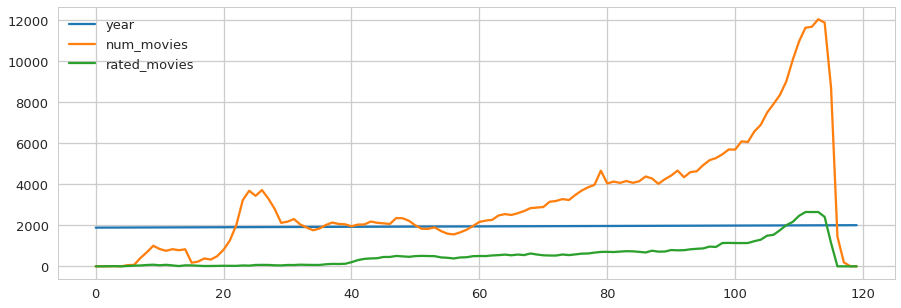

In [15]:
# The plot() command takes the index (the first "column") of the dataframe
# and makes that the x-axis.
# Then it plots *ALL* the numeric columns as a line
df_movies.plot()

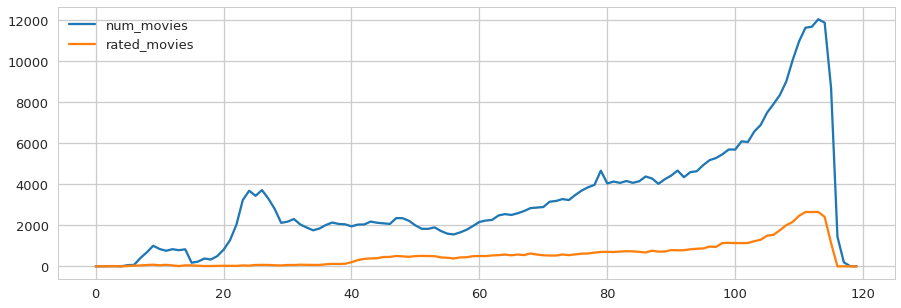

In [16]:
# First step: We can eliminate the "year" line by selecting 
# the columns that we want to plot
# To select columns, we pass a list of the column names that
# we want to keep in square brackets
df_movies[ ["num_movies", "rated_movies"] ].plot() 
# still the x-axis does not list the year

We have a couple of issues. We also plotted the year as a line, and we do not have it as the label of the x-axis. For that, we need to convert the year into a proper datetime variable, and then make it the index for the dataframe.

In [17]:
# We are going to make the "year" column to be the index

# We first convert the column into the right datatype (datetime)
df_movies['year'] = pd.to_datetime(df_movies['year'], format='%Y')
# And now we specify that the (converted) year column should be the index
# The set_index command does not modify the dataframe itself, but rather
# it returns a new dataframe with the new index. That's why we save the 
# result in df_movies2
df_movies2 = df_movies.set_index('year')
df_movies2

,num_movies,rated_movies
year,,
1888-01-01,2,0
1890-01-01,3,1
1891-01-01,6,6
1892-01-01,9,9
1893-01-01,2,1
1894-01-01,59,18
1895-01-01,72,34
1896-01-01,410,43
1897-01-01,688,66


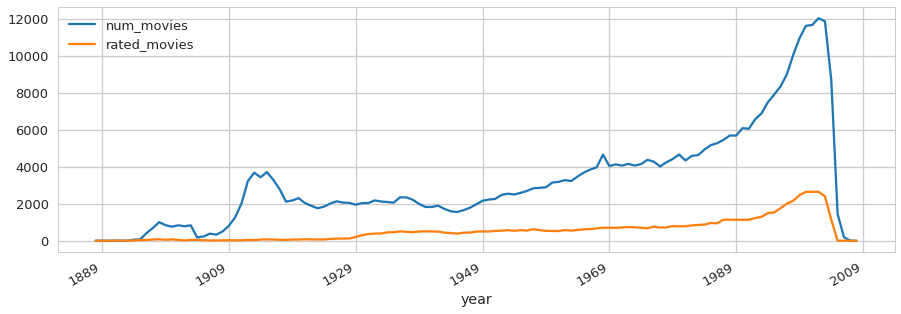

In [18]:
df_movies2.plot()

### Exercise

* Connect to the Facebook database, and use the `MemberSince` variable from the `Profiles` table to plot the growth of Facebook users.
* (_Learn something new_) Use the [cumsum()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.cumsum.html) function of Pandas and plot the total number of registered users over time.

In [106]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='root', 
    password='dwdstudent2015', 
    host = 'localhost', 
    port=3306, 
    db='facebook'
)
engine_fb = create_engine(conn_string_fb)

query = '''
SELECT MemberSince, COUNT(*) AS cnt
FROM Profiles
GROUP BY MemberSince
ORDER BY MemberSince
'''

df_fb = pd.read_sql(query, con=engine_fb)
df_fb.dtypes

MemberSince    datetime64[ns]
cnt                     int64
dtype: object

In [108]:
# Let's assume that MemberSince is not in the right data type (it is right now)
# and we will convert it into a datetime, by specifying the format of the
# date
df_fb['MemberSince'] = pd.to_datetime(df_fb['MemberSince'], format='%Y-%M-%D')
df_fb

,MemberSince,cnt
0,2004-03-07,1
1,2004-03-15,1
2,2004-03-22,44
3,2004-03-23,56
4,2004-03-24,68
5,2004-03-25,95
6,2004-03-26,80
7,2004-03-27,33
8,2004-03-28,31
9,2004-03-29,60


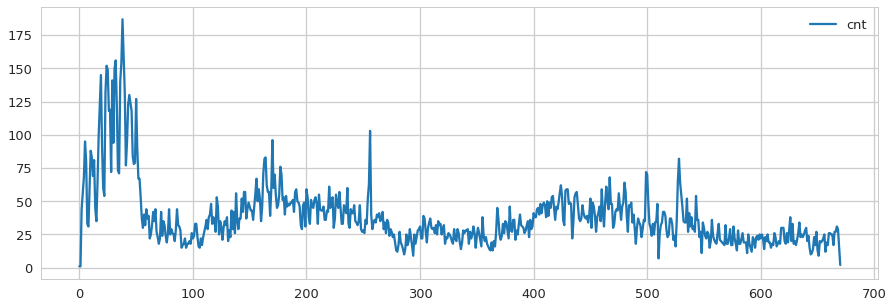

In [111]:
# The basic df_fb.plot() will not run because of the MemberSince column
# However, we can specify that we want to plot just the 'cnt' column
# and we do that by specifying the name of the column within square brackets
df_fb[ 'cnt' ].plot()
# Notice that still the x-axis is not what we want.

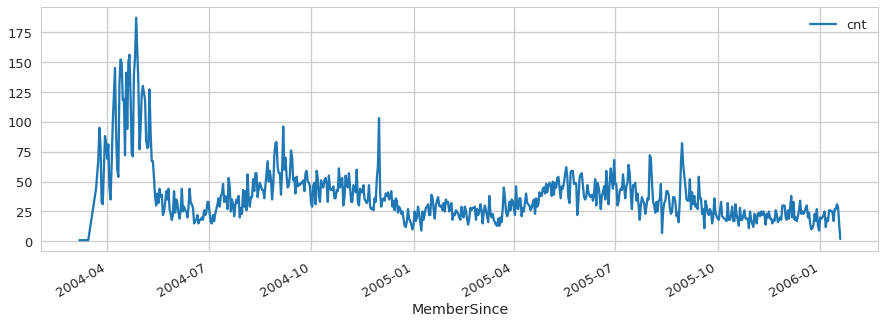

In [114]:
df_fb.set_index('MemberSince').plot()

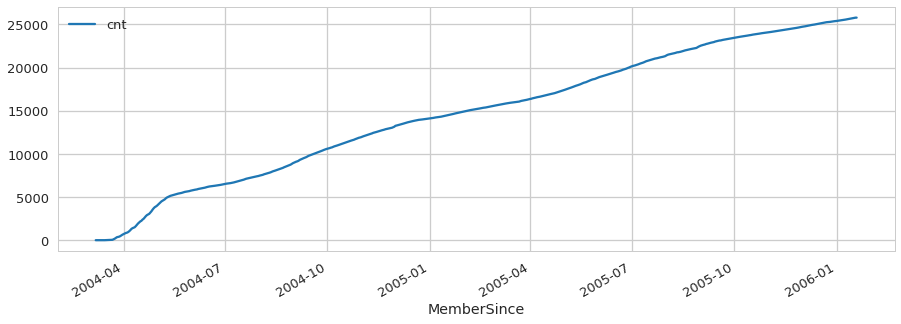

In [121]:
(
    df_fb
    .set_index('MemberSince') # set MemberSince to be the index
    .cumsum() # calculate total number of users until each date
    .plot() # plot the results
)

### Further Examples with SQL and Pandas

Now let's run a query to get the political views of Facebook users, broken down by gender.

In [15]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='root', 
    password='dwdstudent2015', 
    host = 'localhost', 
    port=3306, 
    db='facebook'
)
engine_fb = create_engine(conn_string_fb)

In [16]:
polviews_by_gender = '''
SELECT Sex, `Political Views` AS PoliticalViews, COUNT(*) AS cnt 
FROM Profiles 
WHERE Sex IS NOT NULL AND `Political Views` IS NOT NULL 
GROUP BY Sex, `Political Views`  
ORDER BY  `Political Views`, Sex
'''


And let's get the dataframe:

In [17]:
df = pd.read_sql(polviews_by_gender, con=engine_fb)
df

,Sex,PoliticalViews,cnt
0,Female,Apathetic,309
1,Male,Apathetic,462
2,Female,Conservative,428
3,Male,Conservative,474
4,Female,Liberal,4054
5,Male,Liberal,2196
6,Female,Libertarian,113
7,Male,Libertarian,196
8,Female,Moderate,1444
9,Male,Moderate,1379


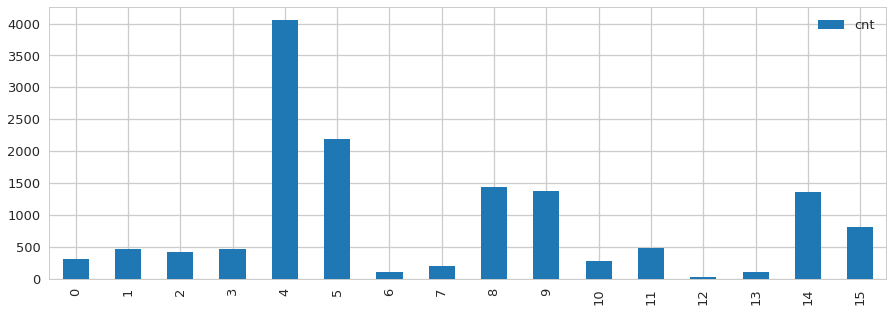

In [18]:
# Let's plot this!
# Bleh, this is really fugly...
# Remember that the index of the dataframe becomes the default x-axis
df.plot(kind='bar')

In [19]:
# Pivot, baby!
# Now the index contains the Political Views, which will be our x-axis
dfp = df.pivot_table(index='PoliticalViews', columns='Sex', values='cnt')
dfp

Sex,Female,Male
PoliticalViews,,
Apathetic,309,462
Conservative,428,474
Liberal,4054,2196
Libertarian,113,196
Moderate,1444,1379
Other,280,482
Very Conservative,38,107
Very Liberal,1362,813


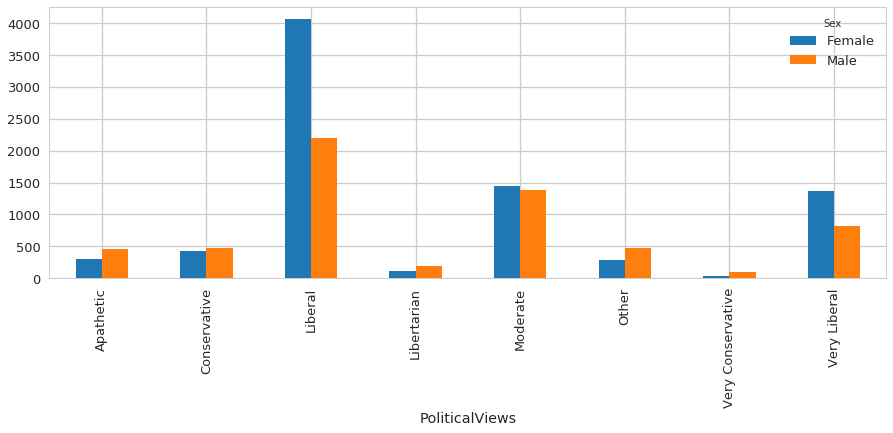

In [20]:
dfp.plot(kind='bar')

In [21]:
dfp.sum() # sums across the rows

Sex
Female    8028
Male      6109
dtype: int64

In [22]:
dfp.sum(axis=1) # this one sums across the columns (axis=1)

PoliticalViews
Apathetic             771
Conservative          902
Liberal              6250
Libertarian           309
Moderate             2823
Other                 762
Very Conservative     145
Very Liberal         2175
dtype: int64

In [23]:
# Let's normalize the columns, as we have more females than males, and it seems that there are always more women
dfp = dfp / dfp.sum()
dfp

Sex,Female,Male
PoliticalViews,,
Apathetic,0.038490,0.075626
Conservative,0.053313,0.077590
Liberal,0.504983,0.359470
Libertarian,0.014076,0.032084
Moderate,0.179870,0.225733
Other,0.034878,0.078900
Very Conservative,0.004733,0.017515
Very Liberal,0.169656,0.133082


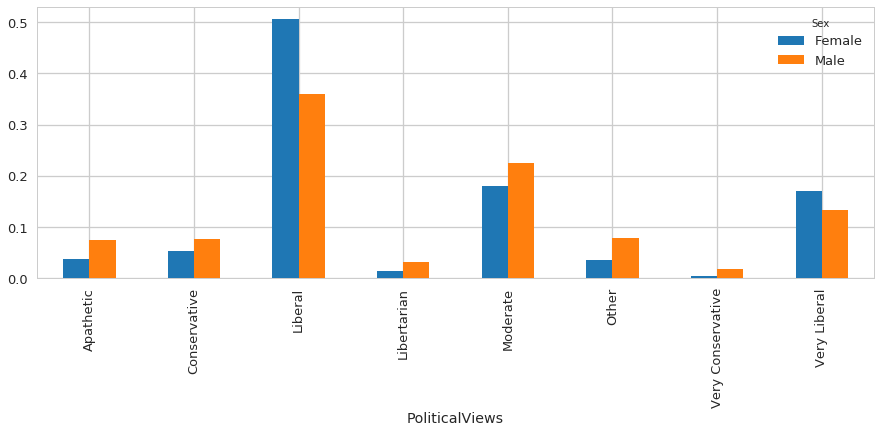

In [24]:
dfp.plot(kind='bar')

In [25]:
# OK, now let's try to re-order the list of results
# according to the logical structure
neworder = ['Very Liberal', 'Liberal', 'Moderate', 'Conservative', 'Very Conservative', 'Libertarian', 'Apathetic', 'Other']
newindex = sorted(dfp.index, key=lambda x: neworder.index(x))
dfp = dfp.reindex(newindex)
dfp

Sex,Female,Male
PoliticalViews,,
Very Liberal,0.169656,0.133082
Liberal,0.504983,0.359470
Moderate,0.179870,0.225733
Conservative,0.053313,0.077590
Very Conservative,0.004733,0.017515
Libertarian,0.014076,0.032084
Apathetic,0.038490,0.075626
Other,0.034878,0.078900


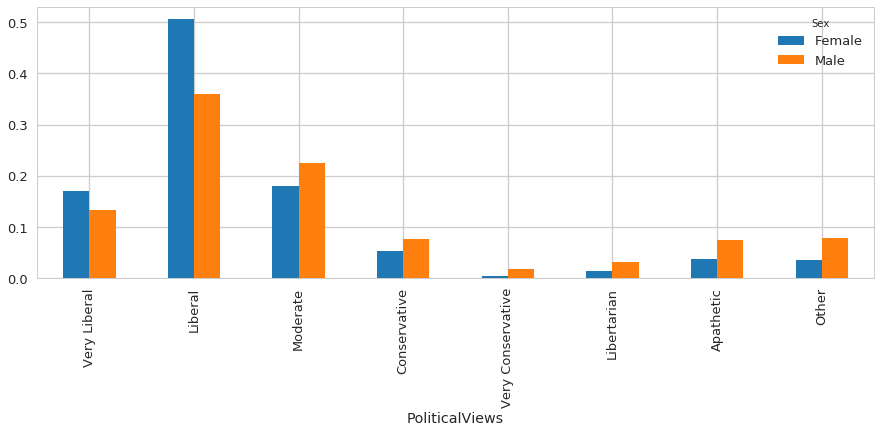

In [26]:
dfp.plot(kind='bar')

### Facebook, Favorite Books, and Political views

In [149]:
books = '''
SELECT F.FavoriteBook, P.`Political Views` AS PoliticalViews, COUNT(*) AS cnt 
FROM Profiles P JOIN FavoriteBooks F ON F.ProfileID = P.ProfileId  
WHERE `Political Views` IS NOT NULL AND F.FavoriteBook IS NOT NULL 
      AND (`Political Views` = 'Liberal' OR `Political Views` = 'Conservative')
GROUP BY F.FavoriteBook, P.`Political Views`
'''

In [150]:
df_books = pd.read_sql(books, con=engine_fb)
df_books.head(10)

,FavoriteBook,PoliticalViews,cnt
0,000 In College Loans And A Meaningless Diploma...,Liberal,1
1,000 Leagues Under The Sea,Liberal,2
2,000 Things To Be Happy About,Liberal,1
3,1,Liberal,1
4,1 Bachelorette,Liberal,1
5,10 Otherland 11 Wheel Of Time Series Ummm Ther...,Liberal,1
6,10 Thousand Sorrows,Liberal,1
7,100 Anos De Soledad,Liberal,1
8,100 People Who Are Screwing Up America,Conservative,1
9,100 Strokes Of The Brush Before Bed,Conservative,1


In [151]:
dfp = df_books.pivot_table(index='FavoriteBook', columns='PoliticalViews', values='cnt')
dfp.head(10)

PoliticalViews,Conservative,Liberal
FavoriteBook,,
000 In College Loans And A Meaningless Diploma Quot,NaN,1.0
000 Leagues Under The Sea,NaN,2.0
000 Things To Be Happy About,NaN,1.0
1,NaN,1.0
1 Bachelorette,NaN,1.0
10 Otherland 11 Wheel Of Time Series Ummm There Are More,NaN,1.0
10 Thousand Sorrows,NaN,1.0
100 Anos De Soledad,NaN,1.0
100 People Who Are Screwing Up America,1.0,NaN


In [152]:
# If we compute the sums, we will see that we have very different 
# number of likes per political view, due to imbalance in the population
dfp.sum()

PoliticalViews
Conservative     3318.0
Liberal         31253.0
dtype: float64

In [153]:
# Normalize the values, so that each column sums up to 1.0
dfp = dfp / dfp.sum()
dfp.head(20)

PoliticalViews,Conservative,Liberal
FavoriteBook,,
000 In College Loans And A Meaningless Diploma Quot,NaN,0.000032
000 Leagues Under The Sea,NaN,0.000064
000 Things To Be Happy About,NaN,0.000032
1,NaN,0.000032
1 Bachelorette,NaN,0.000032
10 Otherland 11 Wheel Of Time Series Ummm There Are More,NaN,0.000032
10 Thousand Sorrows,NaN,0.000032
100 Anos De Soledad,NaN,0.000032
100 People Who Are Screwing Up America,0.000301,NaN


In [154]:
dfp["Liberal_To_Conservative"] = dfp["Liberal"]  / dfp["Conservative"] 
dfp["Conservative_To_Liberal"] = dfp["Conservative"]  / dfp["Liberal"] 

In [155]:
liberal_books = dfp[["Liberal_To_Conservative"]].sort_values("Liberal_To_Conservative", ascending=False).head(10)
liberal_books

PoliticalViews,Liberal_To_Conservative
FavoriteBook,
The Kite Runner,6.582280
The Hours,6.157617
The Bluest Eye,5.414456
Love In The Time Of Cholera,5.308290
The Phantom Tollbooth,4.989793
The Unbearable Lightness Of Being,4.936710
Angels In America,4.883627
Middlesex,4.724378
Beloved,4.565130


In [156]:
conservative_books = dfp[["Conservative_To_Liberal"]].sort_values("Conservative_To_Liberal", ascending=False).head(40)
conservative_books

PoliticalViews,Conservative_To_Liberal
FavoriteBook,
When Genius Failed,37.676914
Liar S Poker,33.909222
Exodus,18.838457
Anything By Nicholas Sparks,18.838457
Juiced,18.838457
French Women Don T Get Fat,18.838457
Fiasco,18.838457
Anything Dave Barry,18.838457
The Hardy Boys,18.838457


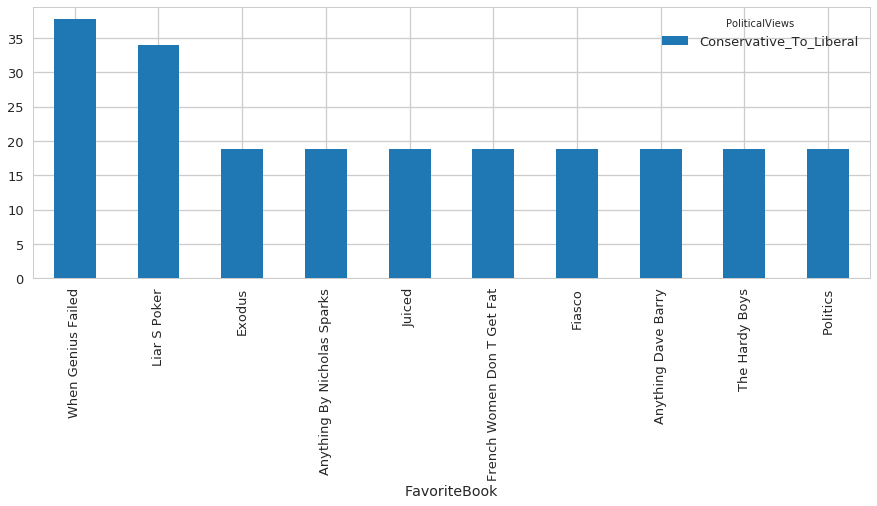

In [33]:
conservative_books.plot(kind='bar')

### Inserting Data in a Database using Pandas

In [19]:
# Read the CSV file
restaurants = pd.read_csv('data/restaurant.csv.gz', encoding="utf-8", dtype="unicode")

In [20]:
# Usual bookkeeping regarding datatypes
restaurants["GRADE DATE"] = pd.to_datetime(restaurants["GRADE DATE"], format="%m/%d/%Y")
restaurants["RECORD DATE"] = pd.to_datetime(restaurants["RECORD DATE"], format="%m/%d/%Y")
restaurants["INSPECTION DATE"] = pd.to_datetime(restaurants["INSPECTION DATE"], format="%m/%d/%Y")
restaurants["SCORE"] = pd.to_numeric(restaurants["SCORE"])
restaurants["BORO"] =  pd.Categorical(restaurants["BORO"], ordered=False)
restaurants["GRADE"] =  pd.Categorical(restaurants["GRADE"], categories = ['A', 'B', 'C'], ordered=True)
restaurants["VIOLATION CODE"] =  pd.Categorical(restaurants["VIOLATION CODE"], ordered=False)
restaurants["CRITICAL FLAG"] =  pd.Categorical(restaurants["CRITICAL FLAG"], ordered=False)
restaurants["ACTION"] =  pd.Categorical(restaurants["ACTION"], ordered=False)
restaurants["CUISINE DESCRIPTION"] =  pd.Categorical(restaurants["CUISINE DESCRIPTION"], ordered=False)

In [21]:
# Connect to the MySQL, but without selecting a database
conn_string = 'mysql://{user}:{password}@{host}:{port}/?charset=utf8'.format(
    user='root', 
    password='dwdstudent2015', 
    host = 'localhost', 
    port=3306, 
    encoding='utf-8'
)
engine = create_engine(conn_string)

In [22]:
# Create the database where we want to store the data
# Do not worry about the Warning if the database already exists
engine.execute('CREATE DATABASE IF NOT EXISTS nyc_restaurant_inspections')
engine.execute('USE nyc_restaurant_inspections')

/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py:470: Warning: (1007, "Can't create database 'nyc_restaurant_inspections'; database exists")
  cursor.execute(statement, parameters)


In [23]:
# We drop the table if it is already there
engine.execute('DROP TABLE IF EXISTS inspections')
# Store the dataframe as a SQL table, using the to_sql command
restaurants.to_sql(name='inspections', # name the table "inspections"
                   con=engine, # use the connection to MySQL created earlier
                   if_exists='replace', # if the table is already there, replace it
                   index=False, # do not write the index column in the database
                   chunksize=1000 # write 1000 lines at a time)
                  )

In [25]:
# And then we can just retrieve it from the database
df = pd.read_sql("SELECT * FROM inspections LIMIT 100", con=engine)
df.head(100)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,41434693,SANSIMIAN JAMAICAN WEST INDIAN RESTAURANT,BROOKLYN,1827,FLATBUSH AVENUE,11210,7182588009,Caribbean,2015-09-14,Violations were cited in the following area(s).,04N,Filth flies or food/refuse/sewage-associated (...,Critical,27.0,None,NaT,2017-11-30,Cycle Inspection / Initial Inspection
1,41591414,NITEHAWK CINEMA,BROOKLYN,136,METROPOLITAN AVENUE,11249,7187828370,American,2014-06-05,Violations were cited in the following area(s).,06A,Personal cleanliness inadequate. Outer garment...,Critical,12.0,A,2014-06-05,2017-11-30,Cycle Inspection / Initial Inspection
2,50012125,SUBWAY,MANHATTAN,30,BROAD ST,10004,2129204568,Sandwiches,2014-09-26,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,5.0,A,2014-09-26,2017-11-30,Pre-permit (Operational) / Initial Inspection
3,50007413,FLUSHING BANGGANE,QUEENS,16519,NORTHERN BLVD,11358,7187622799,Korean,2017-08-14,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Critical,12.0,A,2017-08-14,2017-11-30,Cycle Inspection / Initial Inspection
4,40402527,MADISON SQUARE,MANHATTAN,51,MADISON AVE,10010,2125766303,American,2015-01-13,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,9.0,A,2015-01-13,2017-11-30,Cycle Inspection / Initial Inspection
5,50004317,KENNEDY FRIED CHICKEN,BRONX,2115,GRAND CONCOURSE,10453,6465523988,Chicken,2014-12-24,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,5.0,A,2014-12-24,2017-11-30,Cycle Inspection / Re-inspection
6,41164643,YOGI RESTAURANT,QUEENS,10826,GUY R BREWER BOULEVARD,11433,7182629352,Caribbean,2016-02-13,Violations were cited in the following area(s).,22F,None,Not Applicable,24.0,None,NaT,2017-11-30,Cycle Inspection / Initial Inspection
7,41252132,EUROPAN CAFE,MANHATTAN,2197,BROADWAY,10024,2124966100,CafÃ©/Coffee/Tea,2014-08-08,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,Not Critical,12.0,A,2014-08-08,2017-11-30,Cycle Inspection / Initial Inspection
8,41427008,GORDON BENNETT,BROOKLYN,109,SOUTH 6 STREET,11249,7185999109,American,2014-12-04,Violations were cited in the following area(s).,10E,Accurate thermometer not provided in refrigera...,Not Critical,17.0,None,NaT,2017-11-30,Cycle Inspection / Initial Inspection
9,40377294,MCDONALD'S,QUEENS,7002,COOPER AVENUE,11385,7184970722,Hamburgers,2016-04-21,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,13.0,A,2016-04-21,2017-11-30,Cycle Inspection / Re-inspection
